# Line3 Dataset: Max Projection and ROI Visualization

This notebook:
- Copies ROI `.mat` files from segmented exports into `GT Masks`
- Computes max projection from each `mouse*.h5` video (`mov` dataset)
- Visualizes per mouse: left = max projection, right = union of ROI masks


In [7]:
# Setup
import os
import sys
import glob
from pathlib import Path
import shutil
import h5py
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat

# Use absolute path to the config
CONFIG_PATH = '/gpfs/data/shohamlab/nicole/code/SUNS_nicole/suns/config.py'

import importlib.util
spec = importlib.util.spec_from_file_location('config', CONFIG_PATH)
config = importlib.util.module_from_spec(spec)
spec.loader.exec_module(config)

DATAFOLDER_SETS = config.DATAFOLDER_SETS
ACTIVE_EXP_SET = 'line3_dataset'
EXP_ID_SETS = config.EXP_ID_SETS

root_line3 = DATAFOLDER_SETS[ACTIVE_EXP_SET]
root_gt = os.path.join(root_line3, 'GT Masks')
os.makedirs(root_gt, exist_ok=True)

print('Config loaded from:', CONFIG_PATH)
print('Dataset root:', root_line3)
print('GT Masks folder:', root_gt)
print('Mouse:', EXP_ID_SETS[ACTIVE_EXP_SET])


importing config
Config loaded from: /gpfs/data/shohamlab/nicole/code/SUNS_nicole/suns/config.py
Dataset root: /gpfs/data/shohamlab/nicole/code/SUNS_nicole/demo/line3_dataset
GT Masks folder: /gpfs/data/shohamlab/nicole/code/SUNS_nicole/demo/line3_dataset/GT Masks
Mouse: ['mouse1', 'mouse3', 'mouse5', 'mouse6', 'mouse7', 'mouse9', 'mouse10', 'mouse12', 'mouse14']


In [8]:
# Helper functions: ROI locating, loading, and max projection
SEGMENTED_ROOT = '/gpfs/data/shohamlab/nicole/tifdata/segmented'

# Examples of folder names under segmented: '20190707_mouse1_region1/roi_export/*.mat'
# We'll choose the first roi_export .mat per mouse by date/region order if multiple exist.

def find_roi_mat_for_mouse(mouse_id: str):
    pattern = os.path.join(SEGMENTED_ROOT, f'*_{mouse_id}_*', 'roi_export', '*.mat')
    candidates = sorted(glob.glob(pattern))
    return candidates[0] if candidates else None


def copy_roi_to_gt(mouse_id: str):
    src_mat = find_roi_mat_for_mouse(mouse_id)
    if src_mat is None:
        return None
    dest_mat = os.path.join(root_gt, f'FinalMasks_{mouse_id}.mat')
    if not os.path.exists(dest_mat):
        shutil.copy2(src_mat, dest_mat)
    return dest_mat


def load_dense_masks(mat_path: str) -> np.ndarray:
    # Try HDF5 first
    try:
        with h5py.File(mat_path, 'r') as f:
            if 'FinalMasks' in f:
                arr = np.array(f['FinalMasks'])
                # HDF5 from MATLAB comes as (Ly, Lx, n) in MATLAB → appears transposed sometimes
                # We'll normalize to (n, Ly, Lx)
                if arr.ndim == 3:
                    return np.transpose(arr, (2, 0, 1)).astype(bool)
                return arr.astype(bool)
    except OSError:
        pass
    # Fallback: MATLAB v7
    md = loadmat(mat_path)
    arr = md.get('FinalMasks')
    if arr is None:
        # Some exports might use a different key, attempt a common variant
        arr = md.get('GTMasks_2')
        if arr is None:
            raise KeyError(f'No FinalMasks or GTMasks_2 in {mat_path}')
    if arr.ndim == 3:
        return np.transpose(arr, (2, 0, 1)).astype(bool)
    return arr.astype(bool)


def compute_max_projection(video_h5_path: str) -> np.ndarray:
    with h5py.File(video_h5_path, 'r') as f:
        frames = f['mov']  # (T, Lx, Ly)
        # compute in chunks to avoid memory blow-up
        T = frames.shape[0]
        maxp = None
        chunk = 512
        for start in range(0, T, chunk):
            end = min(T, start + chunk)
            data = frames[start:end]
            cur = np.max(data, axis=0)
            maxp = cur if maxp is None else np.maximum(maxp, cur)
    return maxp.astype(np.float32)


def union_mask(rois_n_ly_lx: np.ndarray) -> np.ndarray:
    # rois shape: (n, Ly, Lx)
    if rois_n_ly_lx.size == 0:
        return None
    return np.any(rois_n_ly_lx, axis=0)


def count_nonempty_rois(rois_n_ly_lx: np.ndarray) -> int:
    # count masks that contain at least one True pixel
    if rois_n_ly_lx.size == 0:
        return 0
    n = rois_n_ly_lx.shape[0]
    flat_any = rois_n_ly_lx.reshape(n, -1).any(axis=1)
    return int(np.count_nonzero(flat_any))


In [9]:
# Copy ROI files into GT Masks if missing
copied = {}
for mouse in EXP_ID_SETS[ACTIVE_EXP_SET]:
    dest = os.path.join(root_gt, f'FinalMasks_{mouse}.mat')
    if os.path.exists(dest):
        copied[mouse] = dest
        print(f'{mouse}: already present -> {dest}')
        continue
    got = copy_roi_to_gt(mouse)
    if got:
        copied[mouse] = got
        print(f'{mouse}: copied from segmented -> {got}')
    else:
        copied[mouse] = None
        print(f'{mouse}: ROI .mat not found under segmented')

copied


mouse1: already present -> /gpfs/data/shohamlab/nicole/code/SUNS_nicole/demo/line3_dataset/GT Masks/FinalMasks_mouse1.mat
mouse3: already present -> /gpfs/data/shohamlab/nicole/code/SUNS_nicole/demo/line3_dataset/GT Masks/FinalMasks_mouse3.mat
mouse5: already present -> /gpfs/data/shohamlab/nicole/code/SUNS_nicole/demo/line3_dataset/GT Masks/FinalMasks_mouse5.mat
mouse6: already present -> /gpfs/data/shohamlab/nicole/code/SUNS_nicole/demo/line3_dataset/GT Masks/FinalMasks_mouse6.mat
mouse7: already present -> /gpfs/data/shohamlab/nicole/code/SUNS_nicole/demo/line3_dataset/GT Masks/FinalMasks_mouse7.mat
mouse9: already present -> /gpfs/data/shohamlab/nicole/code/SUNS_nicole/demo/line3_dataset/GT Masks/FinalMasks_mouse9.mat
mouse10: already present -> /gpfs/data/shohamlab/nicole/code/SUNS_nicole/demo/line3_dataset/GT Masks/FinalMasks_mouse10.mat
mouse12: already present -> /gpfs/data/shohamlab/nicole/code/SUNS_nicole/demo/line3_dataset/GT Masks/FinalMasks_mouse12.mat
mouse14: already pre

{'mouse1': '/gpfs/data/shohamlab/nicole/code/SUNS_nicole/demo/line3_dataset/GT Masks/FinalMasks_mouse1.mat',
 'mouse3': '/gpfs/data/shohamlab/nicole/code/SUNS_nicole/demo/line3_dataset/GT Masks/FinalMasks_mouse3.mat',
 'mouse5': '/gpfs/data/shohamlab/nicole/code/SUNS_nicole/demo/line3_dataset/GT Masks/FinalMasks_mouse5.mat',
 'mouse6': '/gpfs/data/shohamlab/nicole/code/SUNS_nicole/demo/line3_dataset/GT Masks/FinalMasks_mouse6.mat',
 'mouse7': '/gpfs/data/shohamlab/nicole/code/SUNS_nicole/demo/line3_dataset/GT Masks/FinalMasks_mouse7.mat',
 'mouse9': '/gpfs/data/shohamlab/nicole/code/SUNS_nicole/demo/line3_dataset/GT Masks/FinalMasks_mouse9.mat',
 'mouse10': '/gpfs/data/shohamlab/nicole/code/SUNS_nicole/demo/line3_dataset/GT Masks/FinalMasks_mouse10.mat',
 'mouse12': '/gpfs/data/shohamlab/nicole/code/SUNS_nicole/demo/line3_dataset/GT Masks/FinalMasks_mouse12.mat',
 'mouse14': '/gpfs/data/shohamlab/nicole/code/SUNS_nicole/demo/line3_dataset/GT Masks/FinalMasks_mouse14.mat'}

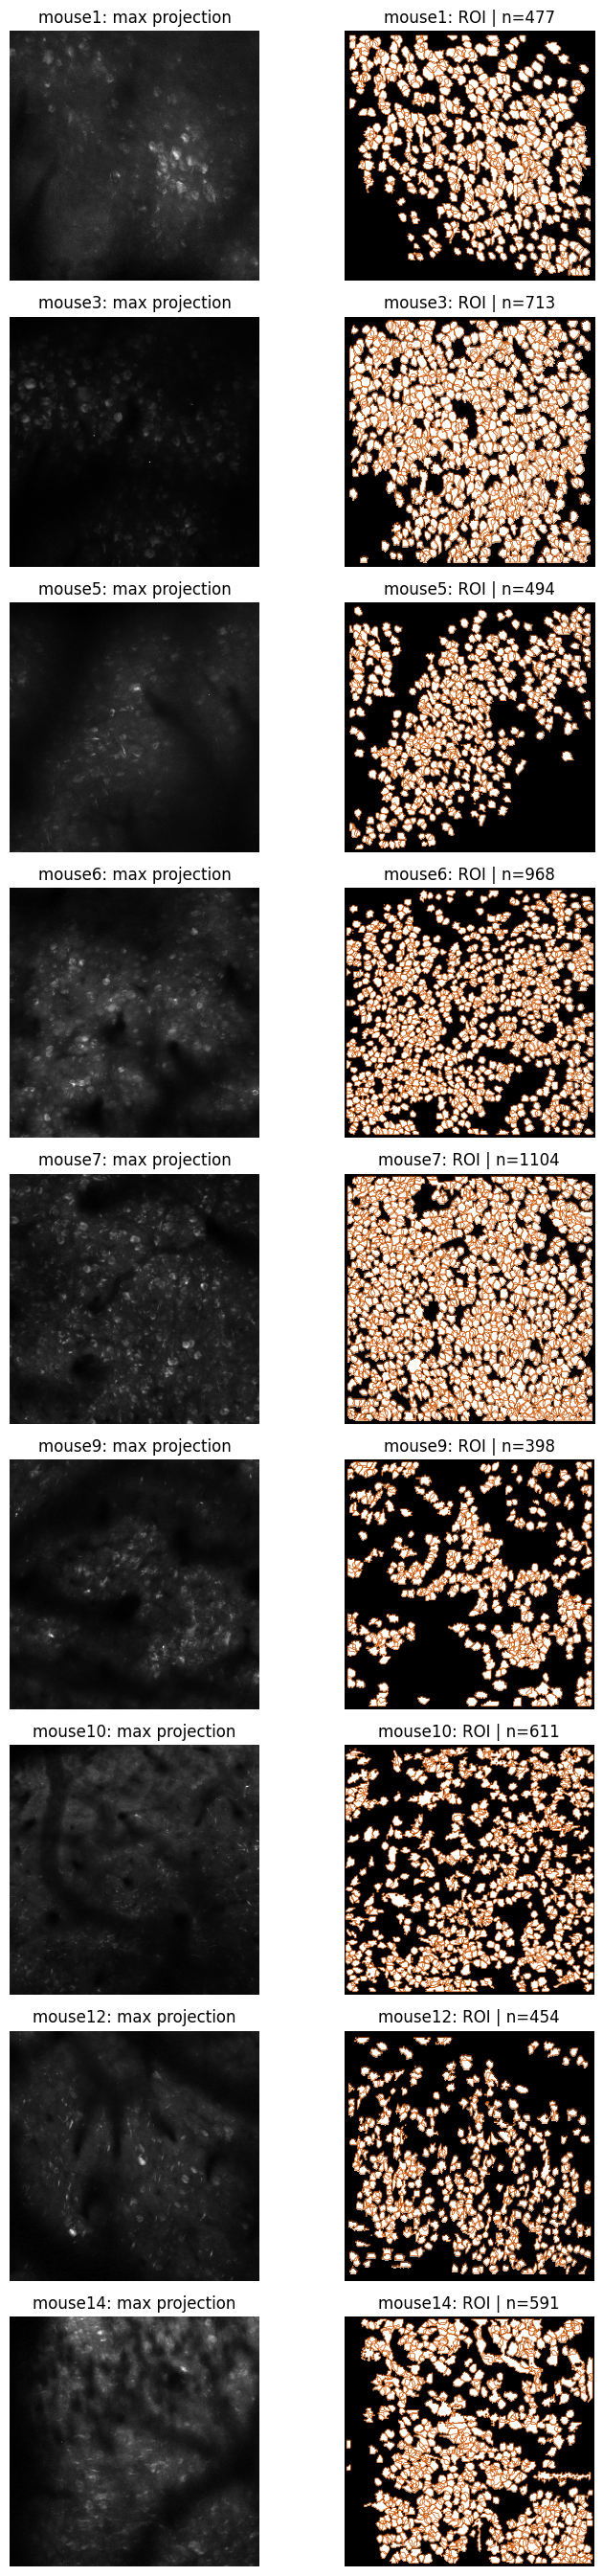

In [10]:
# Visualize per mouse: max projection and ROI union (B/W with contours)

# Decide where the videos are stored: expect /demo/line3_dataset/mouseX.h5
video_paths = {}
for mouse in EXP_ID_SETS[ACTIVE_EXP_SET]:
    candidate = os.path.join(root_line3, f'{mouse}.h5')
    if os.path.exists(candidate):
        video_paths[mouse] = candidate
    else:
        # fallback: search under root_line3
        found = sorted(glob.glob(os.path.join(root_line3, '**', f'{mouse}.h5'), recursive=True))
        video_paths[mouse] = found[0] if found else None

ncols = 2
nrows = len(EXP_ID_SETS[ACTIVE_EXP_SET])
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(8, 3*nrows))
if nrows == 1:
    axes = np.array([axes])

for idx, mouse in enumerate(EXP_ID_SETS[ACTIVE_EXP_SET]):
    ax0, ax1 = axes[idx]

    # Max projection (grayscale)
    vpath = video_paths.get(mouse)
    if vpath and os.path.exists(vpath):
        mp = compute_max_projection(vpath)
        ax0.imshow(mp, cmap='gray', origin='lower')
        ax0.set_title(f'{mouse}: max projection')
    else:
        ax0.text(0.5, 0.5, f'No video for {mouse}', ha='center', va='center')
    ax0.axis('off')

    # ROI masks (binary black/white) + per-ROI contours
    roi_path = os.path.join(root_gt, f'FinalMasks_{mouse}.mat')
    if os.path.exists(roi_path):
        rois = load_dense_masks(roi_path)  # (n, Ly, Lx)
        mask_union = union_mask(rois)      # (Ly, Lx)
        if mask_union is not None:
            ax1.imshow(mask_union.astype(np.float32), cmap='gray', vmin=0, vmax=1, origin='lower')
            n_valid = count_nonempty_rois(rois)
            # Draw per-ROI contours in black, only for non-empty masks
            for i in range(rois.shape[0]):
                if rois[i].any():
                    ax1.contour(
                        rois[i].astype(float),
                        levels=[0.5],
                        colors=[(0.8, 0.33, 0.0)],  # dark orange RGB
                        linewidths=0.5,
                        origin='lower'
                    )
            ax1.set_title(f'{mouse}: ROI | n={n_valid}')
        else:
            ax1.set_title(f'{mouse}: ROI | n=0')
    else:
        ax1.text(0.5, 0.5, f'No ROI for {mouse}', ha='center', va='center')
        ax1.set_title(f'{mouse}: ROI | n=0')
    ax1.axis('off')

plt.tight_layout()
plt.show()
